In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.3 MB/s eta 0:00:00:00:01


In [3]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import math

In [4]:
df_cities = pd.read_csv("cities.csv")

In [5]:
dict(df_cities.apply(lambda x: (x['City'],(x['Latitude'], x['Longitude'])), axis=1).values)

{'New York': (40.7128, -74.006),
 'Los Angeles': (34.0522, -118.2437),
 'Chicago': (41.8781, -87.6298),
 'Houston': (29.7604, -95.3698),
 'Phoenix': (33.4484, -112.074),
 'Philadelphia': (39.9526, -75.1652),
 'San Antonio': (29.4241, -98.4936),
 'San Diego': (32.7157, -117.1611),
 'Dallas': (32.7767, -96.797),
 'San Jose': (37.3382, -121.8863),
 'Austin': (30.2672, -97.7431),
 'Jacksonville': (30.3322, -81.6557),
 'Fort Worth': (32.7555, -97.3308),
 'Columbus': (39.9612, -82.9988),
 'Charlotte': (35.2271, -80.8431),
 'San Francisco': (37.7749, -122.4194),
 'Indianapolis': (39.7684, -86.1581),
 'Seattle': (47.6062, -122.3321),
 'Denver': (39.7392, -104.9903),
 'Washington': (38.9072, -77.0369),
 'Boston': (42.3601, -71.0589),
 'El Paso': (31.7619, -106.485),
 'Nashville': (36.1627, -86.7816),
 'Detroit': (42.3314, -83.0458),
 'Oklahoma City': (35.4676, -97.5164),
 'Portland': (45.5051, -122.675),
 'Las Vegas': (36.1699, -115.1398),
 'Memphis': (35.1495, -90.049),
 'Louisville': (38.2527

In [6]:
cities = {
    "Seattle": (47.6062, -122.3321),
    "San Francisco": (37.7749, -122.4194),
    "Los Angeles": (34.0522, -118.2437),
    "Phoenix": (33.4484, -112.0740),
    "Denver": (39.7392, -104.9903),
    "Dallas": (32.7767, -96.7970),
    "Chicago": (41.8781, -87.6298),
    "Nashville": (36.1627, -86.7816),
    "Atlanta": (33.7490, -84.3880),
    "Miami": (25.7617, -80.1918),
    "Washington D.C.": (38.9072, -77.0369),
    "New York": (40.7128, -74.0060),
    "Boston": (42.3601, -71.0589)
}

# Generated via chat gpt
metro_populations = {
    "Seattle": 4044000,  # Seattle-Tacoma-Bellevue metro area
    "San Francisco": 4720000,  # San Francisco-Oakland-Hayward metro area
    "Los Angeles": 13204000,  # Los Angeles-Long Beach-Anaheim metro area
    "Phoenix": 5100000,  # Phoenix-Mesa-Scottsdale metro area
    "Denver": 2994000,  # Denver-Aurora-Lakewood metro area
    "Dallas": 7740000,  # Dallas-Fort Worth-Arlington metro area
    "Chicago": 9460000,  # Chicago-Naperville-Elgin metro area
    "Nashville": 2001000,  # Nashville-Davidson-Murfreesboro-Franklin metro area
    "Atlanta": 6067000,  # Atlanta-Sandy Springs-Roswell metro area
    "Miami": 6200000,  # Miami-Fort Lauderdale-West Palm Beach metro area
    "Washington D.C.": 6297000,  # Washington-Arlington-Alexandria metro area
    "New York": 20104000,  # New York-Newark-Jersey City metro area
    "Boston": 4943000  # Boston-Cambridge-Newton metro area
}

cities = dict(df_cities.apply(lambda x: (x['City'],(x['Latitude'], x['Longitude'])), axis=1).values)
metro_populations = dict(df_cities[['City', 'Population']].values)

N_cities = len(cities)

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Radius of Earth in kilometers (use 3956 for miles)
    R = 6371.0
    distance = R * c
    
    return distance


In [7]:
#list(metro_populations.keys())

In [8]:
# Randomly generating flows between cities
W_ij = np.zeros((N_cities, N_cities)) #
#W_ij = np.random.randint(1, 101, (13, 13))


# Initializing a matrix to store transportation costs
C_ij = np.zeros((N_cities, N_cities))

# Function to compute Euclidean distance
def compute_distance(coord1, coord2):
    return haversine(coord1[0], coord1[1], coord2[0], coord2[1])
    #return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# Assign transportation costs based on distances
for idx1, city1 in enumerate(cities):
    for idx2, city2 in enumerate(cities):
        distance = compute_distance(cities[city1], cities[city2])
        # Assuming $10 per unit distance for transportation cost
        C_ij[idx1, idx2] = distance * 10

        if city1 != city2:
            W_ij[idx1, idx2] = (metro_populations[city1] + metro_populations[city2] ) / distance**2
        


In [9]:
# Assuming hub construction costs ranging between $100M to $500M
f_k = {city: np.random.randint(100, 501) for city in cities}

#there's a 20% discount on trunk transport between hubs.
alpha = 0.8

In [10]:
pd.DataFrame(W_ij, columns=cities.keys(), index=cities.keys())

,New York,Los Angeles,Chicago,Houston,Phoenix,Philadelphia,San Antonio,San Diego,Dallas,San Jose,...,Long Beach,Virginia Beach,Oakland,Minneapolis,Tulsa,Arlington,Tampa,New Orleans,Wichita,Bakersfield
New York,0.000000,0.800511,8.504337,2.065046,0.852479,595.471147,1.538743,0.644809,2.006194,0.561336,...,0.571173,41.559014,0.522671,3.307426,2.261083,1.768062,3.378416,2.492019,2.134443,0.566310
Los Angeles,0.800511,0.000000,0.851715,1.295998,17.194429,0.376682,1.478131,167.900556,1.341074,20.715647,...,4424.188979,0.305146,14.452745,0.735503,1.060189,1.134940,0.365750,0.605615,1.181870,164.093793
Chicago,8.504337,0.851715,0.000000,2.195272,0.807183,3.769848,1.485053,0.533126,2.419332,0.427677,...,0.401876,2.411930,0.356738,9.658568,3.368933,1.798420,1.189048,1.719650,3.441102,0.394326
Houston,2.065046,1.295998,2.195272,0.000000,1.508276,0.841380,41.836598,0.855796,28.032917,0.500855,...,0.578272,0.721197,0.399022,0.951599,5.365727,19.934499,1.681996,10.398629,3.357025,0.514441
Phoenix,0.852479,17.194429,0.807183,1.508276,0.000000,0.292771,1.743409,13.467381,1.495731,2.779565,...,6.691249,0.198338,1.962609,0.500548,0.933578,1.072578,0.250473,0.465919,1.042513,4.594224
Philadelphia,595.471147,0.376682,3.769848,0.841380,0.292771,0.000000,0.533558,0.207157,0.670920,0.161323,...,0.138272,16.420198,0.123824,0.804191,0.569603,0.442781,0.888607,0.643860,0.529058,0.132452
San Antonio,1.538743,1.478131,1.485053,41.836598,1.743409,0.533558,0.000000,0.904214,17.497510,0.471512,...,0.544071,0.395548,0.349095,0.617127,3.171750,12.712856,0.787083,2.914168,2.263385,0.467310
San Diego,0.644809,167.900556,0.533126,0.855796,13.467381,0.207157,0.904214,0.000000,0.764663,5.453962,...,82.334649,0.132481,3.472686,0.305336,0.468391,0.519347,0.161549,0.271795,0.512956,15.505057
Dallas,2.006194,1.341074,2.419332,28.032917,1.495731,0.670920,17.497510,0.764663,0.000000,0.435105,...,0.457168,0.470942,0.315847,0.915647,11.901456,2005.494718,0.798714,3.421696,5.760751,0.405503
San Jose,0.561336,20.715647,0.427677,0.500855,2.779565,0.161323,0.471512,5.453962,0.435105,0.000000,...,5.548561,0.090719,380.206356,0.227801,0.268900,0.267589,0.098144,0.153077,0.303276,12.396709


In [11]:
pd.DataFrame(C_ij, columns=cities.keys(), index=cities.keys())

,New York,Los Angeles,Chicago,Houston,Phoenix,Philadelphia,San Antonio,San Diego,Dallas,San Jose,...,Long Beach,Virginia Beach,Oakland,Minneapolis,Tulsa,Arlington,Tampa,New Orleans,Wichita,Bakersfield
New York,0.000000,39357.462546,11442.912739,22813.448197,34436.976590,1296.127715,25450.156088,39071.624410,22057.272174,41018.560569,...,39444.281384,4619.499430,41157.198302,16356.570031,19752.197209,22331.939773,16154.516886,18802.996149,20315.889250,39427.858787
Los Angeles,39357.462546,0.000000,28039.715070,22062.640284,5742.658264,38434.534006,19337.661437,1794.104251,19919.875978,4915.527645,...,317.056208,38099.414267,5526.633640,24484.855315,20331.265935,19641.346040,34595.210020,26866.553968,19229.843533,1630.858183
Chicago,11442.912739,28039.715070,0.000000,15158.051068,23363.409880,10680.026387,16942.856953,27866.669584,12949.552776,29575.766915,...,28143.111731,11455.248842,29715.348830,5706.291514,9620.372676,13158.724134,16180.425025,13441.587996,9500.620469,28038.377829
Houston,22813.448197,22062.640284,15158.051068,0.000000,16321.668815,21562.708672,3043.390435,20938.537196,3617.759646,25873.827649,...,21984.914841,19622.796613,26309.538140,17021.248427,7132.915131,3697.943459,12728.312011,5113.479907,8998.030216,22960.270134
Phoenix,34436.976590,5742.658264,23363.409880,16321.668815,0.000000,33440.706669,13626.106037,4808.589832,14235.288013,9883.175375,...,5677.687555,32839.938467,10403.042755,20575.130093,14969.440981,13952.458129,28865.619187,21133.946207,14125.078461,6718.901576
Philadelphia,1296.127715,38434.534006,10680.026387,21562.708672,33440.706669,0.000000,24224.271731,38105.603096,20879.852070,40215.040424,...,38513.767975,3518.677720,40369.894605,15821.303631,18672.546072,21157.158036,14930.949961,17514.106653,19316.203697,38546.365495
San Antonio,25450.156088,19337.661437,16942.856953,3043.390435,13626.106037,24224.271731,0.000000,18126.574336,4062.659922,23355.488200,...,19239.859184,22463.653842,23821.575546,17893.950429,7838.923515,3911.454087,15715.853056,8154.918325,9250.933764,20327.726451
San Diego,39071.624410,1794.104251,27866.669584,20938.537196,4808.589832,38105.603096,18126.574336,0.000000,19015.708255,6700.980114,...,1515.494783,37600.339362,7314.592224,24634.780658,19744.508401,18730.332899,33574.024084,25841.473044,18805.218273,3414.778390
Dallas,22057.272174,19919.875978,12949.552776,3617.759646,14235.288013,20879.852070,4062.659922,19015.708255,0.000000,23319.031579,...,19886.642136,19495.887735,23706.146031,13903.451487,3826.913537,294.468626,14751.266665,7114.644786,5481.620650,20625.177935
San Jose,41018.560569,4915.527645,29575.766915,25873.827649,9883.175375,40215.040424,23355.488200,6700.980114,23319.031579,0.000000,...,5185.542993,40308.807909,619.466692,25264.140618,23036.524318,23060.498309,38064.321037,30414.254092,21600.287066,3371.337996


In [12]:
# Given Data
I = list(range(N_cities))  # Set of nodes, considering 13 cities
P = 4  # Number of hubs

# Model Initialization
m = gp.Model("HubAndSpoke")

# Decision Variables
Y_ik = m.addVars(I, I, vtype=GRB.BINARY, name="Y_ik")
Y_kk = m.addVars(I, vtype=GRB.BINARY, name="Y_kk")

# Objective Function
obj = gp.quicksum(W_ij[i][j] * (C_ij[i][k] * Y_ik[i,k] + alpha * C_ij[k][l] * Y_ik[k,l] + C_ij[l][j] * Y_ik[l,j]) for i in I for j in I for k in I for l in I) + \
    gp.quicksum(f_k[city] * Y_kk[k] for city, k in zip(cities, I))
m.setObjective(obj, GRB.MINIMIZE)

# Constraints
# Constraint 1: Each non-hub node can only be assigned to 1 hub node
for i in I:
    m.addConstr(gp.quicksum(Y_ik[i,k] for k in I) == 1)

# Constraint 2: Limit the number of hub nodes to P
m.addConstr(gp.quicksum(Y_kk[k] for k in I) == P)

# Constraint 3: We cannot assign a non-hub node to a hub node unless we open it
for i in I:
    for k in I:
        m.addConstr(Y_ik[i,k] <= Y_kk[k])

# Solve Model
m.optimize()


Restricted license - for non-production use only - expires 2025-11-24


: 

In [56]:
#dir(obj)

In [49]:
# Print Results
if m.status == GRB.OPTIMAL:
    print('Optimal Objective Value: ', m.objVal)
    hubs = [k for k in I if Y_kk[k].x > 0.5]
    print('Optimal Hub Locations (indexes): ', hubs)
    assignments = {(i,k): Y_ik[i,k].x for i in I for k in I if Y_ik[i,k].x > 0.5}
    print('Assignments: ', assignments)

Optimal Objective Value:  327562824.1294548
Optimal Hub Locations (indexes):  [1, 4, 7, 11]
Assignments:  {(0, 1): 1.0, (1, 1): 1.0, (2, 1): 1.0, (3, 4): 1.0, (4, 4): 1.0, (5, 4): 1.0, (6, 7): 1.0, (7, 7): 1.0, (8, 7): 1.0, (9, 7): 1.0, (10, 11): 1.0, (11, 11): 1.0, (12, 11): 1.0}


In [50]:
# Results can be changed as we used random numbers

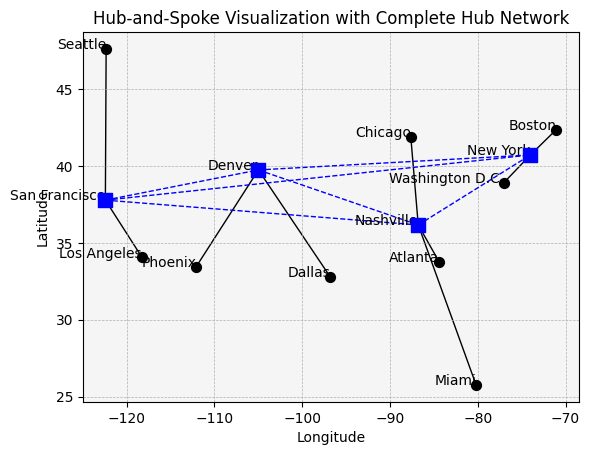

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt

# Extract Results
hubs = [k for k in I if Y_kk[k].x > 0.5]
assignments = {(i,k): Y_ik[i,k].x for i in I for k in I if Y_ik[i,k].x > 0.5}

# Plot Cities and Hubs
for idx, city in enumerate(cities):
    if idx in hubs:
        plt.scatter(cities[city][1], cities[city][0], color='blue', s=100, zorder=5, marker='s')
        plt.text(cities[city][1], cities[city][0], city, fontsize=10, ha='right')
    else:
        plt.scatter(cities[city][1], cities[city][0], color='black', s=50, zorder=5)
        plt.text(cities[city][1], cities[city][0], city, fontsize=10, ha='right')

# Draw Assignments
for (i, k), v in assignments.items():
    if v > 0.5:
        city_i = list(cities.keys())[i]
        city_k = list(cities.keys())[k]
        plt.plot([cities[city_i][1], cities[city_k][1]], [cities[city_i][0], cities[city_k][0]], 'k-', lw=1, zorder=1)

# Create Complete Graph Among Hubs
for idx1, hub1 in enumerate(hubs):
    for idx2, hub2 in enumerate(hubs):
        if idx1 < idx2:
            city1 = list(cities.keys())[hub1]
            city2 = list(cities.keys())[hub2]
            plt.plot([cities[city1][1], cities[city2][1]], [cities[city1][0], cities[city2][0]], 'b--', lw=1, zorder=2)

plt.title("Hub-and-Spoke Visualization with Complete Hub Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.show()
plt.savefig("hub_and_spoke_visualization.png", dpi=300)  

In [34]:
import folium

# Initial map centered around the United States
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Plot hubs (in blue) and non-hubs (in black)
for idx, city in enumerate(cities):
    if idx in hubs:
        folium.Marker(
            location=cities[city],
            icon=folium.Icon(color='blue', icon='cloud'),
            popup=city
        ).add_to(m)
    else:
        folium.Marker(
            location=cities[city],
            popup=city
        ).add_to(m)

# Draw lines connecting non-hubs to their hubs
for (i, k), v in assignments.items():
    if v > 0.5:
        city_i = list(cities.keys())[i]
        city_k = list(cities.keys())[k]
        folium.PolyLine([cities[city_i], cities[city_k]], color="black").add_to(m)

# Create lines to represent the complete graph among hubs
for idx1, hub1 in enumerate(hubs):
    for idx2, hub2 in enumerate(hubs):
        if idx1 < idx2:
            city1 = list(cities.keys())[hub1]
            city2 = list(cities.keys())[hub2]
            folium.PolyLine([cities[city1], cities[city2]], color="blue", dash_array="5, 5").add_to(m)




In [35]:
# Display the map
m